In [1]:
!pip install --no-index --find-links /kaggle/input/detectron2-whls --no-deps yacs portalocker pathspec iopath hydra-core black fvcore detectron2

Looking in links: /kaggle/input/detectron2-whls
Processing /kaggle/input/detectron2-whls/yacs-0.1.8-py3-none-any.whl
Processing /kaggle/input/detectron2-whls/portalocker-3.1.1-py3-none-any.whl
Processing /kaggle/input/detectron2-whls/pathspec-0.12.1-py3-none-any.whl
Processing /kaggle/input/detectron2-whls/iopath-0.1.9-py3-none-any.whl
Processing /kaggle/input/detectron2-whls/hydra_core-1.3.2-py3-none-any.whl
Processing /kaggle/input/detectron2-whls/black-25.1.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl
Processing /kaggle/input/detectron2-whls/fvcore-0.1.5.post20221221-py3-none-any.whl
Processing /kaggle/input/detectron2-whls/detectron2-0.6-cp311-cp311-linux_x86_64.whl


In [2]:
!pip install --no-index --find-links /kaggle/input/cellpose-whl --no-deps cellpose fastremap fill_voids roifile

Looking in links: /kaggle/input/cellpose-whl
Processing /kaggle/input/cellpose-whl/cellpose-4.0.3-py3-none-any.whl
Processing /kaggle/input/cellpose-whl/fastremap-1.16.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing /kaggle/input/cellpose-whl/fill_voids-2.0.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing /kaggle/input/cellpose-whl/roifile-2025.5.10-py3-none-any.whl


In [3]:
# ======================== Detectron2 ========================
import detectron2
import torch
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from PIL import Image
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fastcore.all import *
from skimage.color import label2rgb
from detectron2.structures import Boxes, Instances
detectron2.__version__


# ======================== Cellpose ========================
from cellpose import models, io
import numpy as np
import pandas as pd
from pathlib import Path
import cv2

from tqdm import tqdm


from collections import defaultdict
from tqdm import tqdm
import skimage.io as io
from cellpose import dynamics



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.3 
platform:       	linux 
python version: 	3.11.11 
torch version:  	2.6.0+cu124! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




# Prepare model in advance

In [4]:
# Mask R-CNN 五折模型的檔案路徑
maskrcnn_weights = [
    '/kaggle/input/final-maskrcnn-5fold-models/fold1/best_model.pth',
    # '/kaggle/input/final-maskrcnn-5fold-models/fold2/best_model.pth',
    # '/kaggle/input/final-maskrcnn-5fold-models/fold3/best_model.pth',
    # '/kaggle/input/final-maskrcnn-5fold-models/fold4/best_model.pth',
    # '/kaggle/input/final-maskrcnn-5fold-models/fold5/best_model.pth',
    # '/kaggle/input/detectron2-models-v2/model_0000999.pth'
]

# 每個模型對應的權重 (如需自定)
MASKRCNN_PER_FOLD_WEIGHT = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

# 初始化所有 predictor，使用相同設定 (可依需求修改 config)
def load_maskrcnn_predictor(weight_path):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
    cfg.MODEL.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    cfg.MODEL.WEIGHTS = weight_path
    return DefaultPredictor(cfg)

# 建立 Mask R-CNN 模型列表
maskrcnn_models_list = [
    load_maskrcnn_predictor(w) for w in maskrcnn_weights
]

print(f"Loaded {len(maskrcnn_models_list)} Mask R-CNN models for ensemble.")

Loaded 1 Mask R-CNN models for ensemble.


In [5]:
# Cellpose Ensemble 模型路徑
cellpose_weight_paths = [
    '/kaggle/input/final-cellpose-5fold-models/fold1/best_model.pth',
    # '/kaggle/input/final-cellpose-5fold-models/fold2/best_model.pth',
    # '/kaggle/input/final-cellpose-5fold-models/fold3/best_model.pth',
    # '/kaggle/input/final-cellpose-5fold-models/fold4/best_model.pth',
    # '/kaggle/input/final-cellpose-5fold-models/fold5/best_model.pth',
    # '/kaggle/input/my-cellpose-models/best_model_0.30468207597732544.pth'
]

# 權重比例（可以根據 mAP 手動設定）
CELLPOSE_PER_FOLD_WEIGHT = [1.0, 1.0]

# 初始化 Cellpose 模型
cellpose_models_list = [
    models.CellposeModel(gpu=True, pretrained_model=weight_path)
    for weight_path in cellpose_weight_paths
]


print(f"Loaded {len(cellpose_models_list)} Cellpose models for ensemble.")

Loaded 1 Cellpose models for ensemble.


# helper function

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_flow(avg_dp, image_id="image"):
    """
    視覺化 avg_dp (flow) 結果，包含：
    - dx（水平分量）
    - dy（垂直分量）
    - magnitude（模長）
    """
    if avg_dp.shape[-1] != 2:
        raise ValueError("avg_dp 須為 [H, W, 2] 形狀")

    dx = avg_dp[:, :, 0]
    dy = avg_dp[:, :, 1]
    magnitude = np.sqrt(dx ** 2 + dy ** 2)

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.title(f"{image_id} - Flow dx")
    plt.imshow(dx, cmap="seismic")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.title(f"{image_id} - Flow dy")
    plt.imshow(dy, cmap="seismic")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.title(f"{image_id} - Flow Magnitude")
    plt.imshow(magnitude, cmap="viridis")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

In [7]:
# From https://www.kaggle.com/stainsby/fast-tested-rle
def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [8]:
import pycocotools.mask

def remove_overlap_naive(masks):
    """
    Greedy pixel‐level removal for overlapping masks：
      先把每個 mask 編成 RLE、計算 IoU，再對同一 cluster 的 masks 以貪婪方式移除重疊部分。
    Args:
        masks (np.ndarray): shape = (N, H, W)，二值 mask（uint8 或 bool）。
    Returns:
        np.ndarray: 經過貪婪重疊移除後的 masks，shape = (M, H, W)，M ≤ N。
    """
    if masks.size == 0:
        return masks

    rles = [pycocotools.mask.encode(np.asfortranarray(m.astype(np.uint8))) for m in masks]
    ious = pycocotools.mask.iou(rles, rles, [0] * len(rles))
    np.fill_diagonal(ious, 0)

    toproc = np.where(ious.sum(axis=0) > 0)[0]
    if len(toproc) == 0:
        return masks

    mt = torch.from_numpy(masks.astype(np.uint8)).cuda()
    prev = mt[toproc[0]].clone()
    for idx, i in enumerate(toproc[1:], start=1):
        prev = torch.max(prev, mt[toproc[idx - 1]])
        mt[i] *= (~prev)
    return mt.cpu().numpy()

def instmap_to_masks_boxes(inst_map):
    """
    Convert 2D instance label map → 二值 masks + boxes (x0,y0,x1,y1,area, dummy_score=0)  
    Args:
        inst_map (np.ndarray): shape = (H, W)，稠密 instance map，0=背景，1,2,3...=各實例
    Returns:
        masks (np.ndarray)：shape = (K, H, W)，若無任何實例回傳 (None, None)
        boxes (np.ndarray)：shape = (K, 6)，每行 [x0, y0, x1, y1, area, 0.0]
    """
    masks, boxes = [], []
    for lab in np.unique(inst_map)[1:]:
        m = (inst_map == lab).astype(np.uint8)
        ys, xs = np.where(m)
        if ys.size == 0:
            continue
        area = int(m.sum())
        masks.append(m)
        boxes.append([xs.min(), ys.min(), xs.max(), ys.max(), area, 0.0])
    if not masks:
        return None, None
    return np.stack(masks, axis=0), np.array(boxes, dtype=float)

def weighted_mask_fusion_nmw(masks, boxes, scores, iou_thr=0.15, score_coef=0.8):
    N = masks.shape[0]
    if N == 0:
        return np.zeros((0, masks.shape[1], masks.shape[2]), dtype=np.uint8), np.zeros((0, 6), dtype=float)

    rles = [pycocotools.mask.encode(np.asfortranarray(m)) for m in masks]
    ious = pycocotools.mask.iou(rles, rles, [0] * N)
    used = set()
    fused_masks, fused_boxes = [], []

    for i in range(N):
        if i in used:
            continue
        group = [i]
        for j in range(i + 1, N):
            if ious[i, j] > iou_thr:
                group.append(j)
        used.update(group)

        sub_masks = masks[group]
        sub_boxes = boxes[group]
        sub_scores = scores[group].astype(float) * score_coef

        if len(group) == 1:
            fused_masks.append(sub_masks[0])
            fused_boxes.append(sub_boxes[0])
            continue

        weights = sub_scores / sub_scores.sum()
        soft_map = np.tensordot(weights, sub_masks, axes=(0, 0))
        bin_mask = (soft_map >= 0.5).astype(np.uint8)

        ys, xs = np.where(bin_mask)
        if ys.size == 0:
            best_idx = group[np.argmax(sub_scores)]
            bin_mask = masks[best_idx]
            ys, xs = np.where(bin_mask)
            fused_masks.append(bin_mask)
            fused_boxes.append([xs.min(), ys.min(), xs.max(), ys.max(), int(bin_mask.sum()), 0.0])
        else:
            fused_masks.append(bin_mask)
            fused_boxes.append([xs.min(), ys.min(), xs.max(), ys.max(), int(bin_mask.sum()), 0.0])

    if not fused_masks:
        return np.zeros((0, masks.shape[1], masks.shape[2]), dtype=np.uint8), np.zeros((0, 6), dtype=float)
    return np.stack(fused_masks, axis=0), np.array(fused_boxes, dtype=float)


In [9]:
# -----------------------------
# DIoU 計算
# -----------------------------
def compute_diou(boxes1, boxes2):
    # 保證只取前 4 個座標
    boxes1 = boxes1[:, :4]
    boxes2 = boxes2[:, :4]

    N, M = boxes1.shape[0], boxes2.shape[0]
    diou = np.zeros((N, M), dtype=np.float32)

    for i in range(N):
        x1_1, y1_1, x2_1, y2_1 = boxes1[i]
        area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
        c_x1_1, c_y1_1 = (x1_1 + x2_1) / 2, (y1_1 + y2_1) / 2

        for j in range(M):
            x1_2, y1_2, x2_2, y2_2 = boxes2[j]
            area2 = (x2_2 - x1_2) * (y2_2 - y1_2)

            inter_x1 = max(x1_1, x1_2)
            inter_y1 = max(y1_1, y1_2)
            inter_x2 = min(x2_1, x2_2)
            inter_y2 = min(y2_1, y2_2)
            inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

            union_area = area1 + area2 - inter_area
            iou = inter_area / (union_area + 1e-6)

            c_x1_2, c_y1_2 = (x1_2 + x2_2) / 2, (y1_2 + y2_2) / 2
            center_dist = (c_x1_1 - c_x1_2) ** 2 + (c_y1_1 - c_y1_2) ** 2

            enclose_x1 = min(x1_1, x1_2)
            enclose_y1 = min(y1_1, y1_2)
            enclose_x2 = max(x2_1, x2_2)
            enclose_y2 = max(y2_1, y2_2)
            enclose_diag = (enclose_x2 - enclose_x1) ** 2 + (enclose_y2 - enclose_y1) ** 2

            diou[i, j] = iou - center_dist / (enclose_diag + 1e-6)

    return diou

# -----------------------------
# Weighted Cluster-NMS with DIoU
# -----------------------------
def weighted_mask_fusion_diou_nms(masks, boxes, scores, iou_thr=0.15, overlap_thr=0.2):
    if len(masks) == 0:
        return np.zeros((0, *masks.shape[1:]), dtype=np.uint8), np.zeros((0, 4), dtype=np.float32), np.array([])

    indices = np.argsort(-scores)
    boxes = boxes[indices]
    masks = masks[indices]
    scores = scores[indices]

    keep_masks, keep_boxes, keep_scores = [], [], []
    used = np.zeros(len(scores), dtype=bool)

    for i in range(len(scores)):
        if used[i]:
            continue

        ref_mask = masks[i].astype(np.float32)
        ref_box = boxes[i][:4]  # 只取前 4 維 box
        ref_score = scores[i]

        group = [i]
        weights = [ref_score]
        sum_mask = ref_mask * ref_score

        diou_scores = compute_diou(np.expand_dims(ref_box, 0), boxes[:, :4])[0]
        for j in range(i + 1, len(scores)):
            if used[j]:
                continue
            if diou_scores[j] > iou_thr:
                group.append(j)
                weights.append(scores[j])
                sum_mask += masks[j].astype(np.float32) * scores[j]
                used[j] = True

        fused_mask = (sum_mask / np.sum(weights)) > 0.5

        discard = False
        for kept in keep_masks:
            intersect = np.logical_and(kept, fused_mask).sum()
            if intersect / (fused_mask.sum() + 1e-6) > overlap_thr:
                discard = True
                break

        if not discard:
            keep_masks.append(fused_mask.astype(np.uint8))
            keep_boxes.append(ref_box)
            keep_scores.append(ref_score)

    return np.stack(keep_masks), np.stack(keep_boxes), np.array(keep_scores)

In [10]:
import numpy as np
import cv2
import torch
import pycocotools.mask
from skimage.measure import label, regionprops

# -----------------------------
# Resize Image
# -----------------------------
def resize_image(image, target_h):
    scale = target_h / image.shape[0]
    target_w = int(image.shape[1] * scale)
    resized = cv2.resize(image, (target_w, target_h), interpolation=cv2.INTER_LINEAR)
    return resized, scale

# -----------------------------
# Patch Extraction
# -----------------------------
def get_image_patches(image, patch_h, patch_w, stride_h, stride_w):
    H, W = image.shape[:2]
    patches, coords = [], []
    for y in range(0, H - patch_h + 1, stride_h):
        for x in range(0, W - patch_w + 1, stride_w):
            patch = image[y:y + patch_h, x:x + patch_w]
            patches.append(patch)
            coords.append((y, x))
    return patches, coords

# -----------------------------
# Paste patch-sized masks back to original image coordinates
# -----------------------------
def paste_full_patch_masks(masks, patch_origin, scale_ratio, out_h, out_w):
    py, px = patch_origin
    canvas = np.zeros((len(masks), out_h, out_w), dtype=np.uint8)

    for i, mask in enumerate(masks):
        mask_rescaled = cv2.resize(mask.astype(np.uint8), None, fx=1/scale_ratio, fy=1/scale_ratio, interpolation=cv2.INTER_NEAREST)
        h, w = mask_rescaled.shape
        y0, x0 = int(py / scale_ratio), int(px / scale_ratio)
        y1, x1 = y0 + h, x0 + w

        y1 = min(y1, out_h)
        x1 = min(x1, out_w)
        canvas[i, y0:y1, x0:x1] = mask_rescaled[:y1 - y0, :x1 - x0]

    return canvas

# -----------------------------
# Convert masks to boxes and classes
# -----------------------------
def masks_to_boxes_classes(masks, classes):
    boxes = []
    final_classes = []
    keep_idx = []
    for i, mask in enumerate(masks):
        if mask.sum() == 0:
            continue
        labeled = label(mask)
        props = regionprops(labeled)
        if not props:
            continue
        y0, x0, y1, x1 = props[0].bbox
        area = int(mask.sum())
        boxes.append([x0, y0, x1, y1, area, 0.0])
        final_classes.append(classes[i])
        keep_idx.append(i)
    return np.array(boxes, dtype=float), np.array(final_classes, dtype=int), np.array(keep_idx, dtype=int)

def inverse_boxes(boxes, tta_type, image_shape):
    h, w = image_shape
    boxes = boxes.copy()

    if tta_type == 'hflip':
        boxes[:, 0], boxes[:, 2] = w - boxes[:, 2], w - boxes[:, 0]
    elif tta_type == 'vflip':
        boxes[:, 1], boxes[:, 3] = h - boxes[:, 3], h - boxes[:, 1]
    elif tta_type == 'rot180':
        boxes[:, 0], boxes[:, 2] = w - boxes[:, 2], w - boxes[:, 0]
        boxes[:, 1], boxes[:, 3] = h - boxes[:, 3], h - boxes[:, 1]

    return boxes

# -----------------------------
# Main inference logic
# -----------------------------
def infer_maskrcnn_with_tta_patch_multi_scale(
    image, predictor,
    patch_size=(301, 302), stride=(73, 134),
    scales=(440, 480, 520, 560, 580, 620),
    visualize=False
):
    all_masks, all_boxes, all_scores, all_classes = [], [], [], []

    tta_transforms = [
        lambda x: x,
        lambda x: np.flip(x, axis=1),
        lambda x: np.flip(x, axis=0),
        lambda x: np.rot90(x, k=2),
    ]
    inverse_transforms = [
        lambda m: m,
        lambda m: np.flip(m, axis=2),
        lambda m: np.flip(m, axis=1),
        lambda m: np.rot90(m, k=2, axes=(1, 2)),
    ]
    tta_types = ['none', 'hflip', 'vflip', 'rot180']

    for scale in scales:
        resized_img, scale_ratio = resize_image(image, scale)

        for tta_idx, transform in enumerate(tta_transforms):
            tta_type = tta_types[tta_idx]
            inverse = inverse_transforms[tta_idx]
            tta_img = transform(resized_img)
            patches, coords = get_image_patches(tta_img, *patch_size, *stride)

            for patch, (y, x) in zip(patches, coords):
                m, b, s, c = infer_maskrcnn(patch, predictor)
                if m is None or len(m) == 0:
                    continue

                b[:, [0, 2]] += x
                b[:, [1, 3]] += y
                b = b / scale_ratio
                b = inverse_boxes(b, tta_type, image.shape[:2])

                masks_full = paste_full_patch_masks(
                    masks=m,
                    patch_origin=(y, x),
                    scale_ratio=scale_ratio,
                    out_h=image.shape[0],
                    out_w=image.shape[1]
                )

                masks_full = inverse(masks_full)

                resized = np.zeros((masks_full.shape[0], image.shape[0], image.shape[1]), dtype=np.uint8)
                for i in range(masks_full.shape[0]):
                    resized[i] = cv2.resize(
                        masks_full[i].astype(np.uint8),
                        (image.shape[1], image.shape[0]),
                        interpolation=cv2.INTER_NEAREST
                    )
                masks_full = resized

                if visualize:
                    visualize_maskrcnn_prediction(image, masks_full, b, s)

                all_masks.append(masks_full)
                all_boxes.append(b)
                all_scores.append(s)
                all_classes.append(c)

    if not all_masks:
        return None, None, None, None

    masks_concat = np.concatenate(all_masks, axis=0)
    boxes_concat = np.concatenate(all_boxes, axis=0)
    scores_concat = np.concatenate(all_scores, axis=0)
    classes_concat = np.concatenate(all_classes, axis=0)

    fused_masks, _, fused_scores = weighted_mask_fusion_diou_nms(
        masks_concat, boxes_concat, scores_concat,
        iou_thr=0.15, overlap_thr=0.2
    )

    if fused_masks.shape[0] == 0:
        return None, None, None, None

    fused_boxes, fused_classes, keep_idx = masks_to_boxes_classes(fused_masks, classes_concat)

    fused_masks = fused_masks[keep_idx]
    fused_scores = fused_scores[keep_idx]

    if visualize:
        visualize_maskrcnn_prediction(image, fused_masks, fused_boxes, fused_scores)

    return fused_masks, fused_boxes, fused_scores, fused_classes


In [11]:
# import numpy as np
# import cv2
# import torch
# import pycocotools.mask

# # -----------------------------
# # Resize Image
# # -----------------------------
# def resize_image(image, target_h):
#     scale = target_h / image.shape[0]
#     target_w = int(image.shape[1] * scale)
#     resized = cv2.resize(image, (target_w, target_h), interpolation=cv2.INTER_LINEAR)
#     return resized, scale

# # -----------------------------
# # Patch Extraction
# # -----------------------------
# def get_image_patches(image, patch_h, patch_w, stride_h, stride_w):
#     H, W = image.shape[:2]
#     patches, coords = [], []
#     for y in range(0, H - patch_h + 1, stride_h):
#         for x in range(0, W - patch_w + 1, stride_w):
#             patch = image[y:y + patch_h, x:x + patch_w]
#             patches.append(patch)
#             coords.append((y, x))
#     return patches, coords

# # -----------------------------
# # Paste patch-sized masks back to original image coordinates
# # -----------------------------
# def paste_full_patch_masks(masks, patch_origin, scale_ratio, out_h, out_w):
#     py, px = patch_origin
#     canvas = np.zeros((len(masks), out_h, out_w), dtype=np.uint8)

#     for i, mask in enumerate(masks):
#         mask_rescaled = cv2.resize(mask.astype(np.uint8), None, fx=1/scale_ratio, fy=1/scale_ratio, interpolation=cv2.INTER_NEAREST)
#         h, w = mask_rescaled.shape
#         y0, x0 = int(py / scale_ratio), int(px / scale_ratio)
#         y1, x1 = y0 + h, x0 + w

#         y1 = min(y1, out_h)
#         x1 = min(x1, out_w)
#         canvas[i, y0:y1, x0:x1] = mask_rescaled[:y1 - y0, :x1 - x0]

#     return canvas

# # -----------------------------
# # Filter boxes near patch center
# # -----------------------------
# def filter_boxes_near_patch_center(boxes, patch_size, margin=40):
#     ph, pw = patch_size
#     keep_indices = []
#     for i, box in enumerate(boxes):
#         x0, y0, x1, y1 = box[:4]
#         cx = (x0 + x1) / 2
#         cy = (y0 + y1) / 2
#         if margin < cx < (pw - margin) and margin < cy < (ph - margin):
#             keep_indices.append(i)
#     return keep_indices

# # -----------------------------
# # Re-TTA for boxes
# # -----------------------------
# def retta_boxes(boxes, tta_type, img_height, img_width):
#     boxes_flipped = boxes.copy()

#     if tta_type == 'hflip':
#         boxes_flipped[:, 0] = img_width - boxes[:, 2]
#         boxes_flipped[:, 2] = img_width - boxes[:, 0]

#     elif tta_type == 'vflip':
#         boxes_flipped[:, 1] = img_height - boxes[:, 3]
#         boxes_flipped[:, 3] = img_height - boxes[:, 1]

#     elif tta_type == 'rot180':
#         boxes_flipped[:, 0] = img_width - boxes[:, 2]
#         boxes_flipped[:, 2] = img_width - boxes[:, 0]
#         boxes_flipped[:, 1] = img_height - boxes[:, 3]
#         boxes_flipped[:, 3] = img_height - boxes[:, 1]

#     return boxes_flipped

# # -----------------------------
# # Main inference logic
# # -----------------------------
# def infer_maskrcnn_with_tta_patch_multi_scale(
#     image, predictor,
#     patch_size=(301, 302), stride=(73, 134),
#     scales=(440, 480, 520, 560, 580, 620),
#     center_margin=30, min_mask_area=100,
#     visualize=False
# ):
#     all_masks, all_boxes, all_scores = [], [], []

#     # 定義四種 TTA + 對應反變換
#     tta_transforms = [
#         lambda x: x,
#         lambda x: np.flip(x, axis=1),
#         lambda x: np.flip(x, axis=0),
#         lambda x: np.rot90(x, k=2),
#     ]
#     inverse_transforms = [
#         lambda m: m,
#         lambda m: np.flip(m, axis=2),
#         lambda m: np.flip(m, axis=1),
#         lambda m: np.rot90(m, k=2, axes=(1, 2)),
#     ]
#     tta_types = ['none', 'hflip', 'vflip', 'rot180']

#     for scale in scales:
#         resized_img, scale_ratio = resize_image(image, scale)

#         for tta_idx, transform in enumerate(tta_transforms):
#             inverse = inverse_transforms[tta_idx]
#             tta_type = tta_types[tta_idx]
#             tta_img = transform(resized_img)
#             patches, coords = get_image_patches(tta_img, *patch_size, *stride)

#             for patch, (y, x) in zip(patches, coords):
#                 m, b, s = infer_maskrcnn(patch, predictor)
#                 if m is None or len(m) == 0:
#                     continue

#                 b[:, [0, 2]] += x
#                 b[:, [1, 3]] += y

#                 b_rescaled = b / scale_ratio
#                 areas = (b_rescaled[:, 2] - b_rescaled[:, 0]) * (b_rescaled[:, 3] - b_rescaled[:, 1])
#                 keep_large = areas > 20
#                 m, b_rescaled, s = m[keep_large], b_rescaled[keep_large], s[keep_large]

#                 score_thresh = 0.7
#                 keep_high_score = s >= score_thresh
#                 m, b_rescaled, s = m[keep_high_score], b_rescaled[keep_high_score], s[keep_high_score]
#                 if len(m) == 0:
#                     continue

#                 img_height, img_width = image.shape[:2]
#                 b_rescaled = retta_boxes(b_rescaled, tta_type, img_height=img_height, img_width=img_width)

#                 masks_full = paste_full_patch_masks(
#                     masks=m,
#                     patch_origin=(y, x),
#                     scale_ratio=scale_ratio,
#                     out_h=image.shape[0],
#                     out_w=image.shape[1]
#                 )

#                 # 反變換 (還原 TTA 變形)
#                 masks_full = inverse(masks_full)

#                 # 強制 resize to (H, W)，避免 concat 炸掉
#                 resized = np.zeros((masks_full.shape[0], image.shape[0], image.shape[1]), dtype=np.uint8)
#                 for i in range(masks_full.shape[0]):
#                     resized[i] = cv2.resize(
#                         masks_full[i].astype(np.uint8),
#                         (image.shape[1], image.shape[0]),
#                         interpolation=cv2.INTER_NEAREST
#                     )
#                 masks_full = resized

#                 if visualize:
#                     visualize_maskrcnn_prediction(image, masks_full, b_rescaled, s)

#                 all_masks.append(masks_full)
#                 all_boxes.append(b_rescaled)
#                 all_scores.append(s)

#     if not all_masks:
#         return None, None, None

#     masks_concat = np.concatenate(all_masks, axis=0)
#     boxes_concat = np.concatenate(all_boxes, axis=0)
#     scores_concat = np.concatenate(all_scores, axis=0)

#     fused_masks, fused_boxes = weighted_mask_fusion_nmw(
#         masks_concat, boxes_concat, scores_concat, iou_thr=0.15, score_coef=0.8
#     )

#     if fused_masks.shape[0] == 0:
#         return None, None, None

#     areas = fused_masks.sum(axis=(1, 2))
#     keep = np.where(areas > min_mask_area)[0]
#     fused_masks = fused_masks[keep]
#     fused_boxes = fused_boxes[keep]
#     fused_scores = scores_concat[keep]

#     if visualize:
#         visualize_maskrcnn_prediction(image, fused_masks, fused_boxes, fused_scores)

#     return fused_masks, fused_boxes, fused_scores

In [12]:
def tta_predict_probability_and_flows(model, image, image_id):
    """
    使用測試時間增強 (TTA) 來預測機率圖和流向量。
    包括原始圖像、水平翻轉、垂直翻轉、水平垂直翻轉，
    以及 90 度、180 度、270 度旋轉。

    Args:
        model: Cellpose 模型實例。
        image (np.ndarray): 輸入的原始圖像。
        image_id (str): 圖像的 ID (用於傳遞，本函數中未使用)。

    Returns:
        tuple: (averaged_prob_map, averaged_dp_map)
               - averaged_prob_map (np.ndarray): 平均後的細胞機率圖。
               - averaged_dp_map (np.ndarray): 平均後的流向量圖 (2, H, W)。
    """
    images = [
        image,                                       # 原圖
        np.flip(image, axis=1),                     # 水平翻轉
        np.flip(image, axis=0),                     # 垂直翻轉
        np.flip(np.flip(image, axis=0), axis=1),    # 垂直 + 水平翻轉
        np.rot90(image, k=1),                       # 逆時針 90 度
        np.rot90(image, k=2),                       # 180 度
        np.rot90(image, k=3),                       # 270 度
    ]
    
    # Prob map 對應的 inverse operation
    inverse_ops_prob = [
        lambda x: x,
        lambda x: np.flip(x, axis=1),
        lambda x: np.flip(x, axis=0),
        lambda x: np.flip(np.flip(x, axis=0), axis=1),
        lambda x: np.rot90(x, k=-1),
        lambda x: np.rot90(x, k=-2),
        lambda x: np.rot90(x, k=-3),
    ]
    
    # Flow map 對應的 inverse operation（注意順序）
    inverse_ops_dp = [
        lambda dp: dp,
        lambda dp: np.stack([np.flip(dp[0], axis=1), -np.flip(dp[1], axis=1)], axis=0),
        lambda dp: np.stack([-np.flip(dp[0], axis=0), np.flip(dp[1], axis=0)], axis=0),
        lambda dp: np.stack([
            -np.flip(np.flip(dp[0], axis=0), axis=1),
            -np.flip(np.flip(dp[1], axis=0), axis=1)
        ], axis=0),
        lambda dp: np.stack([
            np.rot90(dp[1], k=-1),
            -np.rot90(dp[0], k=-1)
        ], axis=0),
        lambda dp: np.stack([
            -np.rot90(dp[0], k=-2),
            -np.rot90(dp[1], k=-2)
        ], axis=0),
        lambda dp: np.stack([
            -np.rot90(dp[1], k=-3),
            np.rot90(dp[0], k=-3)
        ], axis=0),
    ]

    all_prob_maps = []
    all_dp_maps = []
    
    # 獲取圖像的原始 H, W (對於 np.rot90 會改變 H, W 的順序，但我們處理的是原始圖像尺寸)
    # Cellpose 的 eval_flows 應該會根據圖像的實際尺寸來處理
    # 不過為了保險，可以在 `inverse_ops_dp` 裡面對 `np.rot90` 的結果進行尺寸調整
    # 但 Cellpose 內部通常會處理輸入圖像的尺寸變化，並輸出正確尺寸的流場，
    # 所以這裡主要確保逆變換的邏輯正確。
    H, W = image.shape[:2] 

    for idx, aug_img in enumerate(images):
        _, eval_flows, _ = model.eval(aug_img, compute_masks=False)
        
        pred_dp_map_raw = eval_flows[1].astype(np.float32)
        pred_prob_map_raw = eval_flows[2].astype(np.float32)

        # 執行機率圖的逆變換
        pred_prob_map = inverse_ops_prob[idx](pred_prob_map_raw)
        
        # 執行流向量圖的逆變換
        pred_dp_map_transformed = inverse_ops_dp[idx](pred_dp_map_raw)

        if pred_prob_map.shape[:2] != (H, W):
            pred_prob_map = cv2.resize(pred_prob_map, (W, H), interpolation=cv2.INTER_LINEAR)
        if pred_dp_map_transformed.shape[1:] != (H, W):
            pred_dp_map_transformed_x = cv2.resize(pred_dp_map_transformed[0], (W, H), interpolation=cv2.INTER_LINEAR)
            pred_dp_map_transformed_y = cv2.resize(pred_dp_map_transformed[1], (W, H), interpolation=cv2.INTER_LINEAR)
            pred_dp_map_transformed = np.stack([pred_dp_map_transformed_x, pred_dp_map_transformed_y], axis=0)


        all_prob_maps.append(pred_prob_map)
        all_dp_maps.append(pred_dp_map_transformed)

    # 對所有增強圖像的預測結果進行平均
    averaged_prob_map = np.mean(all_prob_maps, axis=0)
    averaged_dp_map = np.mean(all_dp_maps, axis=0)
    
    return averaged_prob_map, averaged_dp_map

In [13]:
from detectron2.structures import Instances, Boxes
import torch
from detectron2.utils.visualizer import Visualizer

def visualize_maskrcnn_prediction(image, masks, boxes, scores):
    H, W = image.shape[:2]
    instances = Instances((H, W))
    instances.pred_masks = torch.tensor(masks).bool()
    instances.pred_boxes = Boxes(torch.tensor(boxes[:, :4]))
    instances.scores = torch.tensor(scores)

    visualizer = Visualizer(image[:, :, ::-1], scale=1.0)
    out = visualizer.draw_instance_predictions(instances)
    plt.figure(figsize=(12, 12))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()

In [14]:
def infer_maskrcnn(image, predictor, score_thresh=[0.7, 0.7, 0.7]):
    """
    使用 Detectron2 的 DefaultPredictor 推論，根據 class 對應的 score 門檻過濾。
    Args:
        image (np.ndarray): shape = (H, W, 3)
        predictor: Detectron2 DefaultPredictor
        score_thresh (list[float]): 每類 class 的 score 過濾門檻，例如 [0.7, 0.5, 0.3]
    Returns:
        masks (np.ndarray): shape = (N, H, W)
        boxes (np.ndarray): shape = (N, 6) → [x0, y0, x1, y1, area, 0.0]
        scores (np.ndarray): shape = (N,)
        classes (np.ndarray): shape = (N,) → class index (int)
    """
    outputs = predictor(image)
    instances = outputs["instances"].to("cpu")  # ✅ 只最後再搬到 CPU，避免 GPU → CPU 早搬

    if len(instances) == 0:
        return None, None, None, None

    pred_masks  = instances.pred_masks.numpy()              # (N, H, W)
    pred_boxes  = instances.pred_boxes.tensor.numpy()       # (N, 4)
    scores      = instances.scores.numpy()                  # (N,)
    classes     = instances.pred_classes.numpy()            # (N,)

    # ✅ 利用 np.where 快速取 index（避免 for loop）
    keep = np.where([
        cls < len(score_thresh) and scores[i] >= score_thresh[cls]
        for i, cls in enumerate(classes)
    ])[0]

    if len(keep) == 0:
        return None, None, None, None

    pred_masks = pred_masks[keep]
    pred_boxes = pred_boxes[keep]
    scores     = scores[keep]
    classes    = classes[keep]

    areas = pred_masks.sum(axis=(1, 2)).astype(float)
    boxes_with_extra = np.hstack([
        pred_boxes,
        areas[:, None],
        np.zeros((len(areas), 1))  # fake score placeholder
    ])

    return pred_masks, boxes_with_extra, scores, classes

In [15]:
def ensemble_and_generate_submission(test_dir, output_csv='submission.csv', min_size=75):
    test_files = sorted([f for f in Path(test_dir).iterdir() if f.suffix == '.png'])
    submission_data = []

    # 每個類別的 score 門檻與最小像素數
    SCORE_THRESHOLDS = [0.7, 0.45, 0.4]
    MIN_PIXELS = [80, 150, 60]

    for img_path in tqdm(test_files, desc='推證中'):
        img_id = img_path.stem
        img = io.imread(img_path)
        img_rgb = img if img.ndim == 3 and img.shape[2] == 3 else (
            img[..., :3] if img.ndim == 3 and img.shape[2] == 4 else np.stack([img]*3, axis=-1)
        )
        H, W = img.shape[:2]
        all_masks, all_boxes, all_scores, all_classes = [], [], [], []

        # === Mask R-CNN Ensemble ===
        for model in maskrcnn_models_list:
            m, b, s, c = infer_maskrcnn(img_rgb, model)
            if m is not None:
                print("=================== Non-Patch ===================")
                visualize_maskrcnn_prediction(img_rgb, m, b, s)
                all_masks.append(m)
                all_boxes.append(b[:, :4])
                all_scores.append(s)
                all_classes.append(c)

            m_, b_, s_, c_ = infer_maskrcnn_with_tta_patch_multi_scale(img_rgb, model)
            if m_ is not None:
                print("=================== Patch + TTA ===================")
                visualize_maskrcnn_prediction(img_rgb, m_, b_, s_)
                all_masks.append(m_)
                all_boxes.append(b_[:, :4])
                all_scores.append(s_)
                all_classes.append(c_)

        # === Cellpose 加權平均之後再 decode ===
        prob_map_sum, dp_map_sum, total_weight = None, None, 0.0
        cp_device = 'cpu'
        for i_model, cp_model in enumerate(cellpose_models_list):
            prob_map, dp_map = tta_predict_probability_and_flows(cp_model, img_rgb, img_id)
            weight = CELLPOSE_PER_FOLD_WEIGHT[i_model]

            if prob_map_sum is None:
                prob_map_sum = prob_map * weight
                dp_map_sum = dp_map * weight
            else:
                prob_map_sum += prob_map * weight
                dp_map_sum += dp_map * weight

            total_weight += weight
            cp_device = cp_model.device

        if total_weight > 0:
            avg_prob_map = prob_map_sum / total_weight
            avg_dp_map = dp_map_sum / total_weight
            print("=================== Cellpose ===================")
            new_dp = np.moveaxis(avg_dp_map, 0, -1)
            visualize_flow(new_dp)

            inst_map = dynamics.resize_and_compute_masks(
                avg_dp_map, avg_prob_map, flow_threshold=0.4, min_size=20, device=cp_device)

            if inst_map.max() > 0:
                m_bin, bxs = instmap_to_masks_boxes(inst_map)
                if m_bin is not None:
                    scores = [float(avg_prob_map[mask.astype(bool)].mean()) if mask.sum() > 0 else 0.0 for mask in m_bin]
                    all_masks.append(m_bin)
                    all_boxes.append(bxs[:, :4])
                    all_scores.append(np.array(scores))
                    all_classes.append(np.zeros(len(scores), dtype=np.int32))  # Cellpose 類別固定為 0

        # === 無任何預測情況 ===
        if not all_masks:
            submission_data.append({'id': img_id, 'predicted': ''})
            continue

        # === 合併所有預測 + 權重融合（改為 DIoU-NMS） ===
        masks_concat = np.concatenate(all_masks, axis=0)
        boxes_concat = np.concatenate(all_boxes, axis=0)
        scores_concat = np.concatenate(all_scores, axis=0)
        classes_concat = np.concatenate(all_classes, axis=0)

        fused_masks, fused_boxes, fused_scores = weighted_mask_fusion_diou_nms(
            masks_concat, boxes_concat, scores_concat
        )

        # 依據類別篩選 min_pixel + score threshold
        if fused_masks.shape[0] > 0:
            areas = fused_masks.sum(axis=(1, 2))
            keep = []
            for i in range(fused_masks.shape[0]):
                cls = classes_concat[i]
                score = fused_scores[i]
                area = areas[i]
                if score >= SCORE_THRESHOLDS[cls] and area >= MIN_PIXELS[cls]:
                    keep.append(i)

            if len(keep) == 0:
                submission_data.append({'id': img_id, 'predicted': ''})
                continue

            fused_masks = fused_masks[keep]
            fused_boxes = fused_boxes[keep]
            fused_scores = fused_scores[keep]
            classes_concat = classes_concat[keep]

        # === Connected Components 後處理 + RLE 編碼 ===
        canvas = np.zeros((H, W), dtype=np.int32)
        instance_id = 1
        for i, m in enumerate(fused_masks):
            mask = m.astype(bool)
            assign_area = mask.sum()
            if assign_area < MIN_PIXELS[classes_concat[i]]:
                continue

            num_connected, _ = cv2.connectedComponents(mask.astype(np.uint8))
            if num_connected > 2:
                continue

            overlap_ratio = (canvas & mask).sum() / assign_area if assign_area > 0 else 1.0
            if overlap_ratio > 0.2:
                continue

            canvas[mask] = instance_id
            instance_id += 1

        if canvas.max() > 0:
            instance_ids = np.unique(canvas)[1:]
            for inst_id in instance_ids:
                binary_mask = (canvas == inst_id).astype(np.uint8)
                rle = rle_encode(binary_mask)
                submission_data.append({'id': img_id, 'predicted': rle})
        else:
            submission_data.append({'id': img_id, 'predicted': ''})

    # === 輸出 CSV ===
    submission_df = pd.DataFrame(submission_data, columns=['id', 'predicted'])
    all_test_ids = [f.stem for f in test_files]
    missing_ids = set(all_test_ids) - set(submission_df['id'].unique())
    for img_id in missing_ids:
        submission_df = pd.concat(
            [submission_df, pd.DataFrame([{'id': img_id, 'predicted': ''}])],
            ignore_index=True
        )
    submission_df = submission_df.sort_values(by='id').reset_index(drop=True)
    submission_df.to_csv(output_csv, index=False)
    print(f"✅ 輸出完成：{output_csv}")

推證中:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


=================== Non-Patch ===================


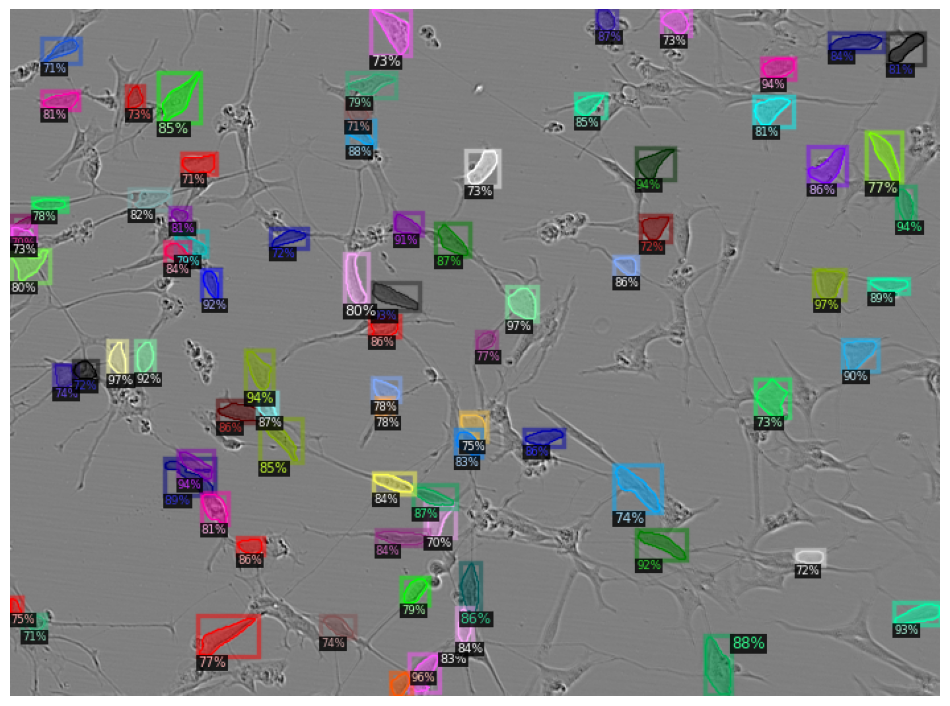

=================== Patch + TTA ===================


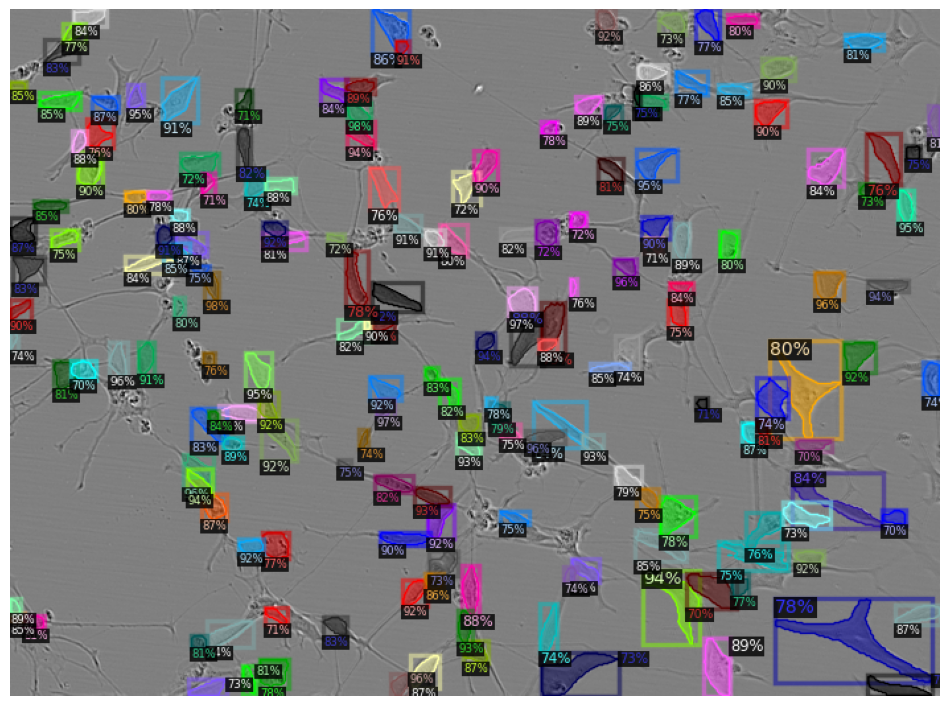

=================== Cellpose ===================


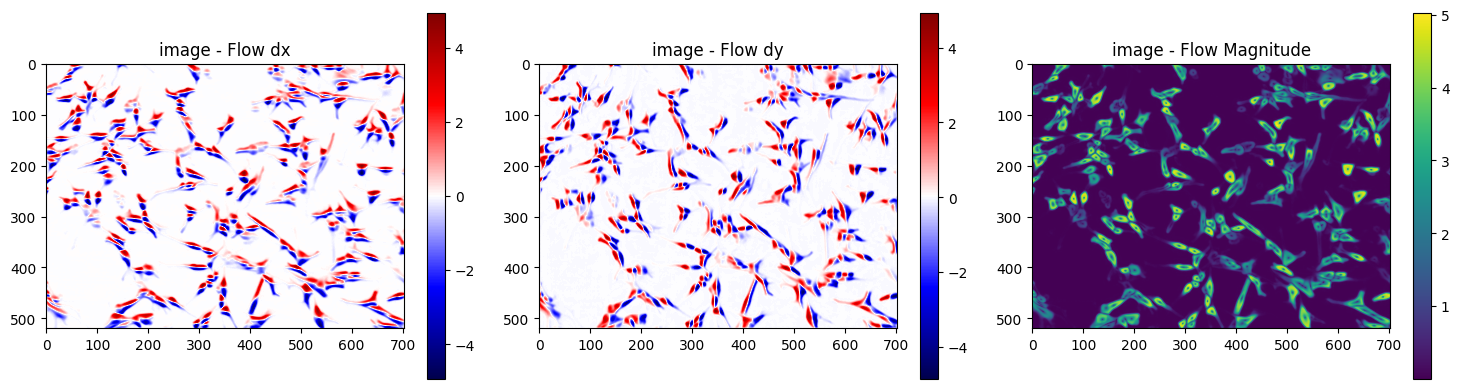

推證中:  33%|███▎      | 1/3 [01:22<02:45, 82.73s/it]

=================== Non-Patch ===================


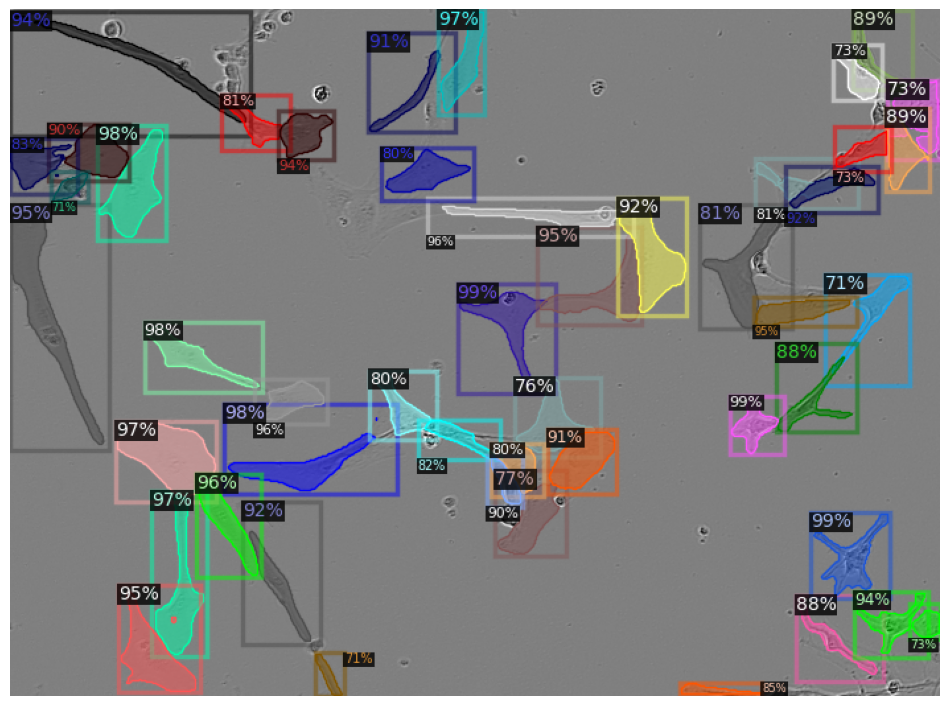

=================== Patch + TTA ===================


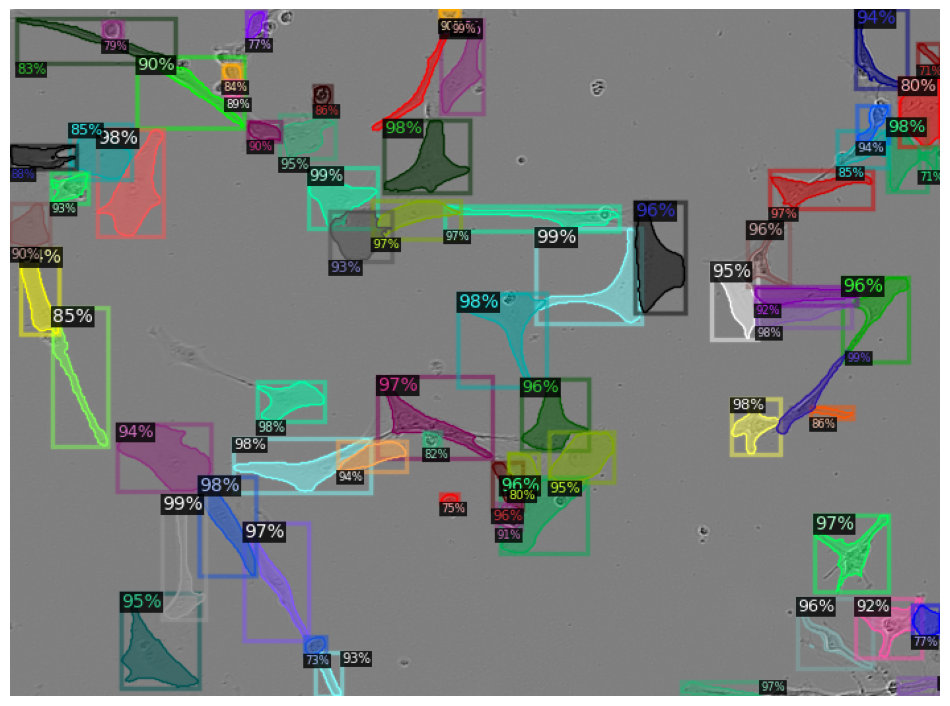

=================== Cellpose ===================


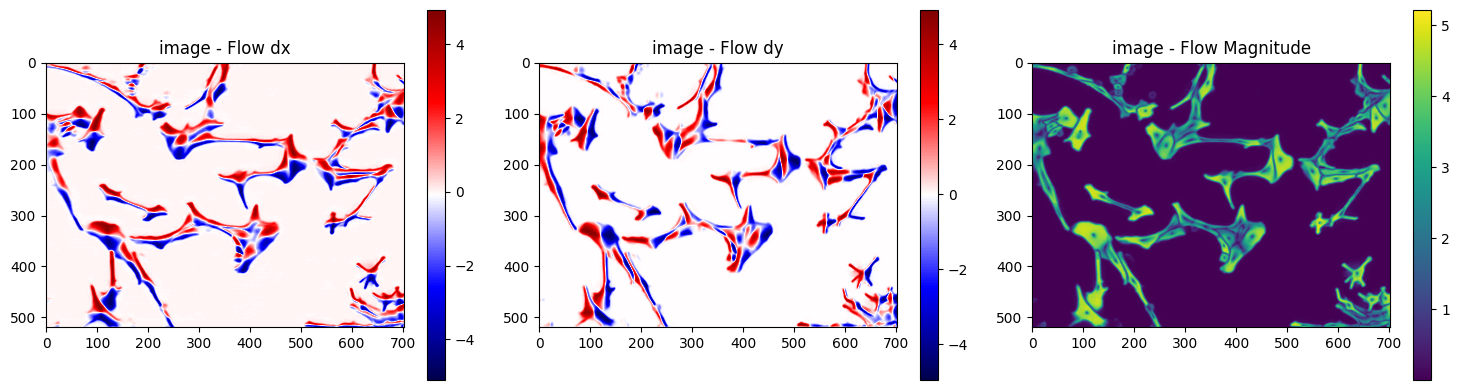

推證中:  67%|██████▋   | 2/3 [02:11<01:02, 62.91s/it]

=================== Non-Patch ===================


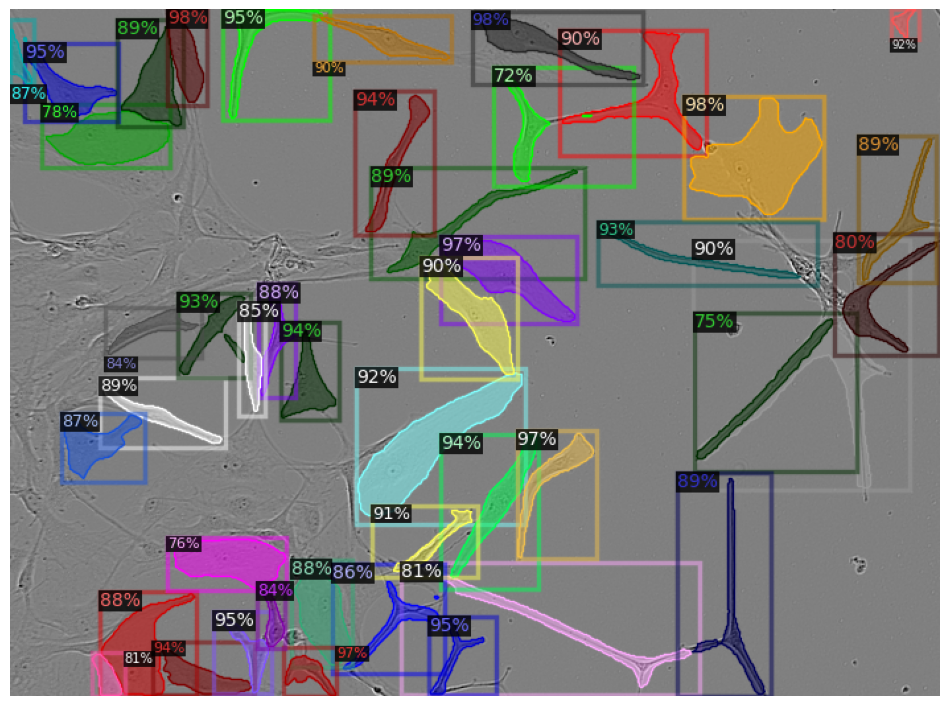

=================== Patch + TTA ===================


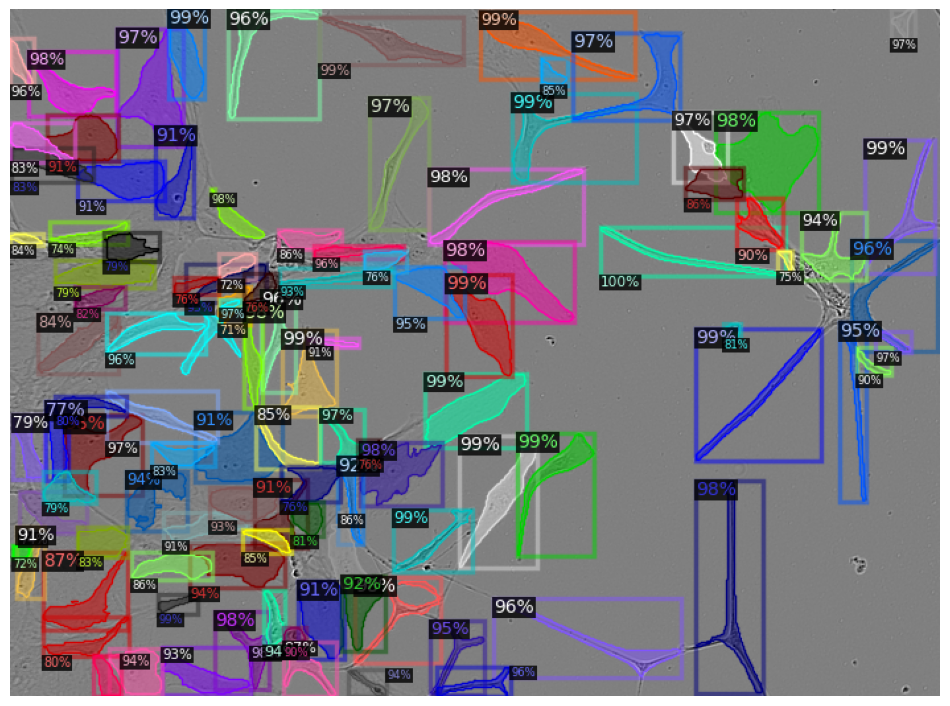

=================== Cellpose ===================


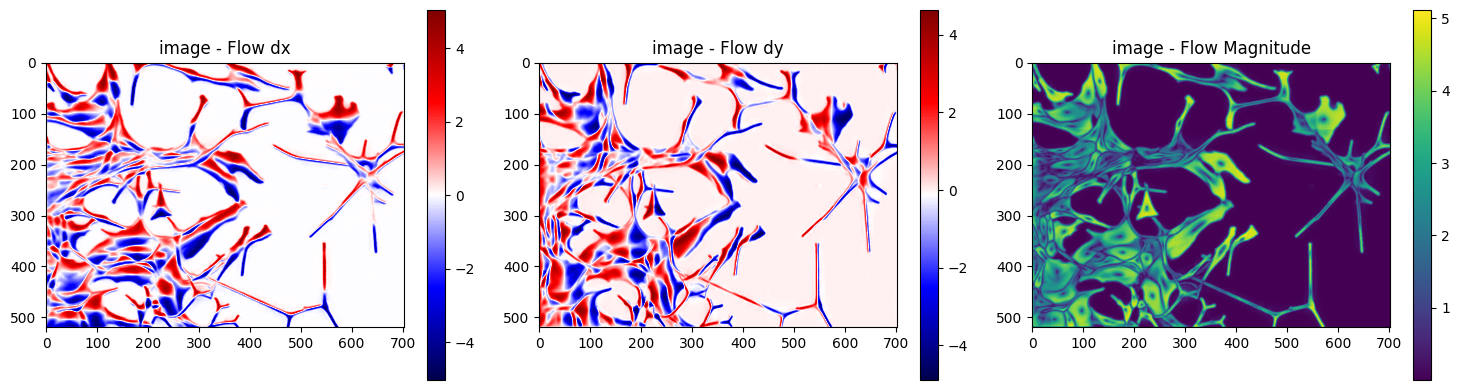

推證中: 100%|██████████| 3/3 [03:11<00:00, 63.96s/it]

✅ 輸出完成：submission.csv


In [16]:
test_dir = Path('/kaggle/input/sartorius-cell-instance-segmentation/test')
ensemble_and_generate_submission(test_dir=test_dir)

In [17]:
from collections import defaultdict
from tqdm import tqdm

submission_df = pd.read_csv('submission.csv')

# === 建立 rle_dict 從 submission_df 讀入 ===
rle_dict = defaultdict(list)
for _, row in submission_df.iterrows():
    rle_dict[row['id']].append(row['predicted'])

# === 檢查是否有 pixel 重疊 ===
overlap_count = 0
for img_id, rles in tqdm(rle_dict.items(), desc="🔍 檢查像素重疊"):
    mask_sum = np.zeros((520, 704), dtype=np.uint8)
    for rle_text in rles:
        if isinstance(rle_text, float) and np.isnan(rle_text):
            continue
        if rle_text.strip() == '':
            continue
        mask = rle_decode(rle_text, (520, 704))
        mask_sum += mask
    if (mask_sum > 1).any():
        print(f"⚠️ 圖像 {img_id} 有重疊的 pixel！")
        overlap_count += 1

if overlap_count == 0:
    print("✅ 所有圖像都沒有重疊 pixel")
else:
    print(f"⚠️ 共 {overlap_count} 張圖像有重疊問題，建議檢查合併策略")

🔍 檢查像素重疊: 100%|██████████| 3/3 [00:00<00:00, 113.74it/s]

✅ 所有圖像都沒有重疊 pixel


In [18]:
# ✅ 檢查
submission_df = pd.read_csv('submission.csv')

print(submission_df.head())
print("欄位名稱:", submission_df.columns)
print("是否有 null:", submission_df.isnull().sum())
print("是否有空字串 predicted:", (submission_df['predicted'].astype(str).str.strip() == '').sum())
print("是否有 duplicated id + predicted:", submission_df.duplicated(subset=["id", "predicted"]).any())
print("id 總數:", submission_df['id'].nunique(), "submission 行數:", len(submission_df))
print("predicted 欄型別:", submission_df['predicted'].apply(type).value_counts())

             id                                          predicted
0  7ae19de7bc2a  140004 14 140706 20 141410 22 142114 22 142818...
1  7ae19de7bc2a  291178 1 291881 3 292585 5 293289 7 293993 8 2...
2  7ae19de7bc2a  137 18 841 20 1546 20 2251 19 2956 17 3660 11 ...
3  7ae19de7bc2a  263888 2 264591 6 265294 9 265997 11 266700 14...
4  7ae19de7bc2a  229407 1 229409 2 230098 21 230801 25 231504 2...
欄位名稱: Index(['id', 'predicted'], dtype='object')
是否有 null: id           0
predicted    0
dtype: int64
是否有空字串 predicted: 0
是否有 duplicated id + predicted: False
id 總數: 3 submission 行數: 340
predicted 欄型別: predicted
<class 'str'>    340
Name: count, dtype: int64


In [19]:
import random
import numpy as np

def random_color(seed=None):
    if seed is not None:
        random.seed(seed)
    return [random.randint(0, 255) for _ in range(3)]

def mask_to_color(mask):
    """
    將多個 instance mask 合成彩色圖像。
    mask: numpy array, shape = (N, H, W)
    return: RGB 彩色 mask，shape = (H, W, 3)
    """
    if mask.ndim == 2:
        mask = mask[np.newaxis, ...]  # 單一 mask 也包成 (1, H, W)

    h, w = mask.shape[1:]
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for i in range(mask.shape[0]):
        color = random_color(seed=i)
        color_mask[mask[i] > 0] = color
    return color_mask

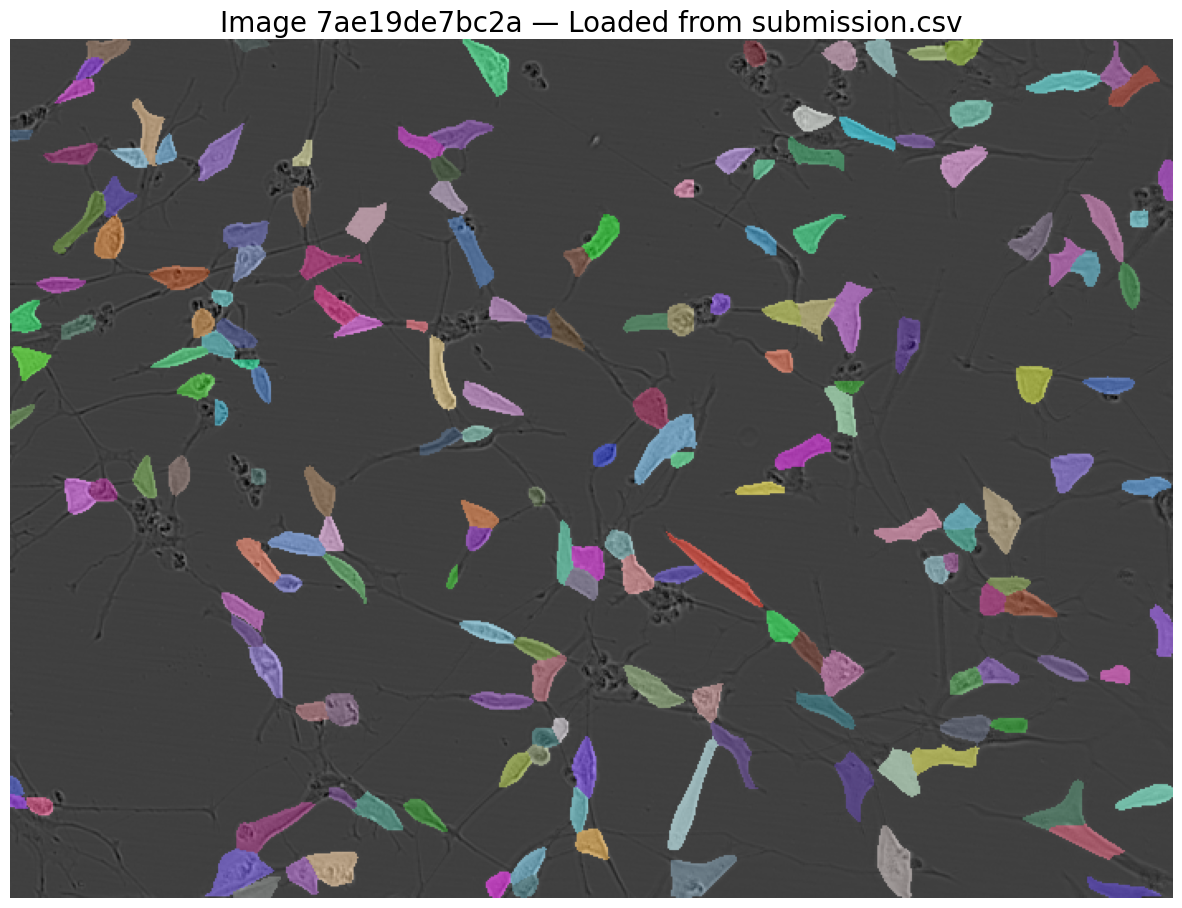

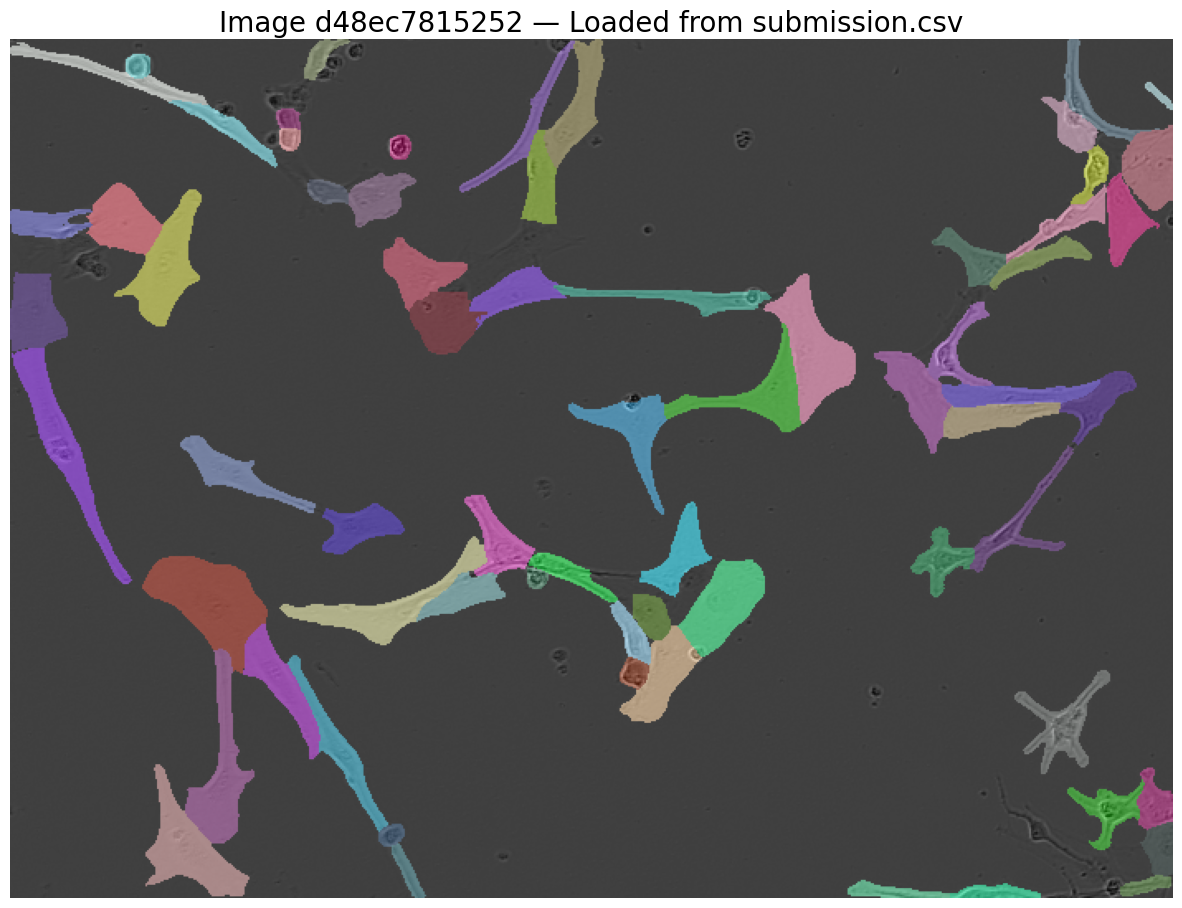

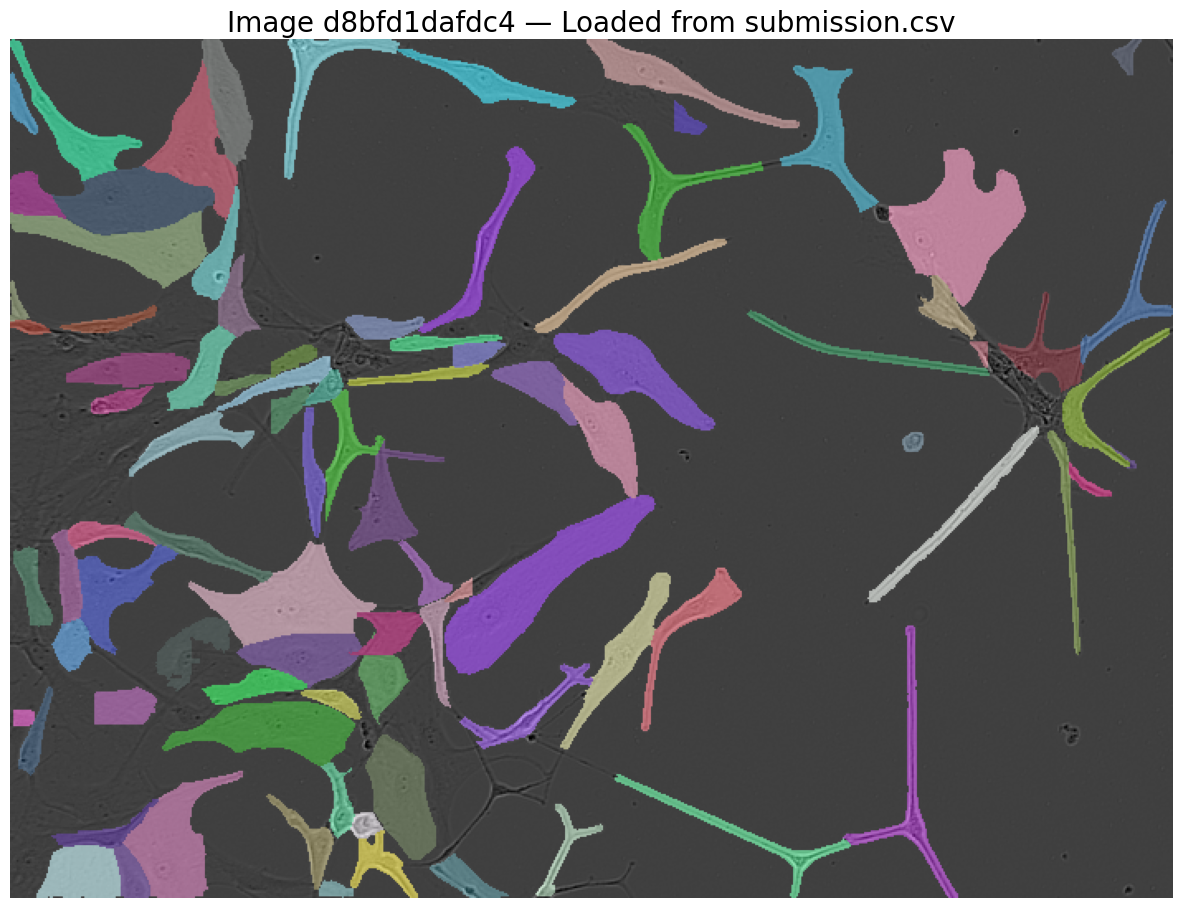

In [20]:
visualized_ids = submission_df['id'].unique()

for img_id in visualized_ids:
    img_path = test_dir / f"{img_id}.png"
    image = cv2.imread(str(img_path))

    masks_rle = submission_df[submission_df['id'] == img_id]['predicted'].tolist()
    decoded_masks = []

    for rle in masks_rle:
        if isinstance(rle, str) and rle.strip() != '':
            decoded = rle_decode(rle, shape=(520, 704))
            decoded_masks.append(decoded)

    if len(decoded_masks) == 0:
        print(f"⚠️ {img_id} 沒有預測到 mask")
        continue

    instance_masks = np.array(decoded_masks)
    colored_mask = mask_to_color(instance_masks)

    plt.figure(figsize=(15, 15))
    plt.imshow(image[..., ::-1])
    plt.imshow(colored_mask, alpha=0.5)
    plt.axis("off")
    plt.title(f"Image {img_id} — Loaded from submission.csv", fontsize=20)
    plt.show()